In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


# Dataset

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

def downloadFlowerData():
    '''Download flower detection dataset from alxmamaev/flowers-recognition.'''
    api = KaggleApi()
    api.authenticate()
    try:
        api.dataset_download_files('alxmamaev/flowers-recognition', path='data/',quiet=False) #do not forget to add kaggle.json into Users/.kaggle/
    except:
        return -1
    return 0

def checkDataset():
    # Check dataset zip file
    if(not os.path.exists('data/flowers-recognition.zip')):
        print("flowers dataset not found, downloading from kaggle")
        if(downloadFlowerData()==-1):
            print("Downloading dataset fail, please check kaggle.json is correct or try again with stable internet connection")
            os.remove('data/flowers-recognition.zip')
            quit()
    
    # Extract Data
    if(not os.path.exists('data/flowers/')):
        print("Extracting flowers-recognition.zip")
        with ZipFile('data/flowers-recognition.zip') as file:
            file.extractall('data/')
        print("Done")

import os, fnmatch
from PIL import Image
import numpy as np
import random

def convertToGrayscale(imageRGB):
    """return grayscale conversion of RGB image"""
    # https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html
    # Basically  Grayscale = 0.299⋅R + 0.587⋅G + 0.114⋅B
    # We could easily vectorized and just do the dot product of imageRGB with [0.299,0.587,0.114]

    imageGrayscale = np.dot(imageRGB, [0.299,0.587,0.114])

    return imageGrayscale


def getImages(label, n=100):
    """return list of (default 100) images for a given label"""

    # Check Dataset
    checkDataset()

    # Try and get path
    path = "data/flowers/" + label.lower()
    if(not os.path.exists(path)):
        print("No label found")
        return -1
    
    # Get all images address
    allFiles = fnmatch.filter(os.listdir(path), '*.jpg')
    random.seed(42)
    usedFiles = random.sample(allFiles, n) # get 100 samples from allFiles

    # Read the data into numpy array
    imagesRGB = []
    for file in usedFiles:
        img = Image.open(path+'/'+file)
        img = img.resize((320,240), Image.ANTIALIAS)
        imagesRGB.append(np.asarray(img))
    
    imagesRGB = np.asarray(imagesRGB) #(n, 240, 320, 3)

    return imagesRGB

def preprocessImage(images): 
    """return np.array to be loaded into a model,
    flatten dimension (100, 240, 320) -> (100, 76800), and 
    Normalize data value from int [0, 255] -> float [0,1]"""

    x = images.reshape(*images.shape[:1], -1) #(100, 76800)
    x = x/255.0
    return x

# CNN Model

# Get Dataset

In [ ]:
labels = ['Sunflower', 'Dandelion', 'Rose']
n_data = 100

X = None
y = None
for i in range(len(labels)):
    if(X is None):
        X = getImages(labels[i], n=n_data)
    else:
        X = np.append(X, getImages(labels[i], n=n_data), axis=0)

    if(y is None):
        y = np.full(shape=n_data,fill_value=i,dtype=np.int)
    else:
        y = np.append(y, np.full(shape=n_data,fill_value=i,dtype=np.int), axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
n_values = np.max(y) + 1
y = np.eye(n_values)[y]
print(y.shape)
X = X/255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

(300, 3)


## Model 1


In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(1),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

In [ ]:
history = model.fit(X_train, y_train, batch_size=5, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
48/48 [==============================] - 9s 172ms/step - loss: 26.3646 - acc: 0.4292 - val_loss: 6.9899 - val_acc: 0.4667
Epoch 2/30
48/48 [==============================] - 8s 167ms/step - loss: 3.0518 - acc: 0.4750 - val_loss: 1.1940 - val_acc: 0.6167
Epoch 3/30
48/48 [==============================] - 8s 165ms/step - loss: 1.3805 - acc: 0.5583 - val_loss: 1.0602 - val_acc: 0.4500
Epoch 4/30
48/48 [==============================] - 8s 164ms/step - loss: 0.9857 - acc: 0.6083 - val_loss: 0.9877 - val_acc: 0.5333
Epoch 5/30
48/48 [==============================] - 8s 165ms/step - loss: 0.9847 - acc: 0.5583 - val_loss: 1.0624 - val_acc: 0.5167
Epoch 6/30
48/48 [==============================] - 8s 166ms/step - loss: 0.9141 - acc: 0.6167 - val_loss: 0.9789 - val_acc: 0.5833
Epoch 7/30
48/48 [==============================] - 8s 164ms/step - loss: 0.9151 - acc: 0.6042 - val_loss: 0.8703 - val_acc: 0.5667
Epoch 8/30
48/48 [==============================] - 8s 165ms/step - loss: 0

## Model 2

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(1),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(3, activation='softmax')
])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

In [ ]:
history2 = model2.fit(X_train, y_train, batch_size=5, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
48/48 [==============================] - 11s 207ms/step - loss: 5.6437 - acc: 0.4875 - val_loss: 1.2052 - val_acc: 0.7000
Epoch 2/30
48/48 [==============================] - 10s 202ms/step - loss: 0.9117 - acc: 0.5917 - val_loss: 0.8025 - val_acc: 0.6833
Epoch 3/30
48/48 [==============================] - 10s 201ms/step - loss: 0.8116 - acc: 0.6458 - val_loss: 0.9146 - val_acc: 0.5500
Epoch 4/30
48/48 [==============================] - 10s 202ms/step - loss: 0.7668 - acc: 0.6750 - val_loss: 0.8303 - val_acc: 0.6333
Epoch 5/30
48/48 [==============================] - 10s 202ms/step - loss: 0.8501 - acc: 0.7042 - val_loss: 0.8308 - val_acc: 0.6333
Epoch 6/30
48/48 [==============================] - 10s 201ms/step - loss: 0.7721 - acc: 0.6708 - val_loss: 0.8172 - val_acc: 0.6333
Epoch 7/30
48/48 [==============================] - 10s 201ms/step - loss: 0.6892 - acc: 0.7000 - val_loss: 0.8655 - val_acc: 0.6333
Epoch 8/30
48/48 [==============================] - 10s 202ms/step - 

## Model 3

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(3, activation='softmax')
])
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

In [ ]:
history3 = model3.fit(X_train, y_train, batch_size=5, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
48/48 [==============================] - 14s 280ms/step - loss: 14.8921 - acc: 0.5333 - val_loss: 7.2417 - val_acc: 0.4167
Epoch 2/30
48/48 [==============================] - 13s 269ms/step - loss: 2.1029 - acc: 0.5833 - val_loss: 1.5290 - val_acc: 0.5000
Epoch 3/30
48/48 [==============================] - 13s 268ms/step - loss: 0.9645 - acc: 0.6625 - val_loss: 0.9964 - val_acc: 0.5500
Epoch 4/30
48/48 [==============================] - 13s 267ms/step - loss: 1.0302 - acc: 0.6875 - val_loss: 0.9447 - val_acc: 0.5833
Epoch 5/30
48/48 [==============================] - 13s 267ms/step - loss: 0.7666 - acc: 0.6875 - val_loss: 0.8448 - val_acc: 0.5667
Epoch 6/30
48/48 [==============================] - 13s 266ms/step - loss: 0.7395 - acc: 0.7458 - val_loss: 0.8819 - val_acc: 0.5667
Epoch 7/30
48/48 [==============================] - 13s 266ms/step - loss: 0.6539 - acc: 0.7833 - val_loss: 1.0595 - val_acc: 0.6167
Epoch 8/30
48/48 [==============================] - 13s 266ms/step -

## Model 4

In [ ]:
model4 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(1),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(3, activation='softmax')
])
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

In [ ]:
history4 = model4.fit(X_train, y_train, batch_size=5, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
48/48 [==============================] - 23s 458ms/step - loss: 25.7016 - acc: 0.4667 - val_loss: 2.3736 - val_acc: 0.6500
Epoch 2/30
48/48 [==============================] - 21s 434ms/step - loss: 1.0705 - acc: 0.6625 - val_loss: 0.8671 - val_acc: 0.6833
Epoch 3/30
48/48 [==============================] - 21s 431ms/step - loss: 0.8146 - acc: 0.7083 - val_loss: 0.8120 - val_acc: 0.6167
Epoch 4/30
48/48 [==============================] - 21s 429ms/step - loss: 0.7477 - acc: 0.6792 - val_loss: 0.7263 - val_acc: 0.6667
Epoch 5/30
48/48 [==============================] - 21s 428ms/step - loss: 0.6900 - acc: 0.7500 - val_loss: 0.6640 - val_acc: 0.6667
Epoch 6/30
48/48 [==============================] - 21s 428ms/step - loss: 0.7206 - acc: 0.6792 - val_loss: 0.8364 - val_acc: 0.7000
Epoch 7/30
48/48 [==============================] - 21s 430ms/step - loss: 0.6892 - acc: 0.7083 - val_loss: 0.6124 - val_acc: 0.7500
Epoch 8/30
48/48 [==============================] - 21s 430ms/step -

## Model 5

In [ ]:
model5 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(1),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(3, activation='softmax')
])
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

history5 = model5.fit(X_train, y_train, batch_size=5, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
48/48 [==============================] - 39s 777ms/step - loss: 29.1982 - acc: 0.5042 - val_loss: 1.7445 - val_acc: 0.6000
Epoch 2/30
48/48 [==============================] - 36s 753ms/step - loss: 1.1784 - acc: 0.6458 - val_loss: 0.7386 - val_acc: 0.6833
Epoch 3/30
48/48 [==============================] - 36s 749ms/step - loss: 0.7798 - acc: 0.6875 - val_loss: 0.7217 - val_acc: 0.6167
Epoch 4/30
48/48 [==============================] - 36s 746ms/step - loss: 0.8016 - acc: 0.6792 - val_loss: 0.7510 - val_acc: 0.6833
Epoch 5/30
48/48 [==============================] - 36s 750ms/step - loss: 0.7593 - acc: 0.7042 - val_loss: 0.7277 - val_acc: 0.7167
Epoch 6/30
48/48 [==============================] - 36s 748ms/step - loss: 0.6771 - acc: 0.7333 - val_loss: 0.7031 - val_acc: 0.7667
Epoch 7/30
48/48 [==============================] - 36s 751ms/step - loss: 0.6022 - acc: 0.7375 - val_loss: 0.6358 - val_acc: 0.7333
Epoch 8/30
48/48 [==============================] - 36s 749ms/step -

## Plot

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
models_histories = {'n_filters_08':history,'n_filters_16':history2,'n_filters_32':history3, 'n_filters_64':history4, 'n_filters_128':history5}


In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

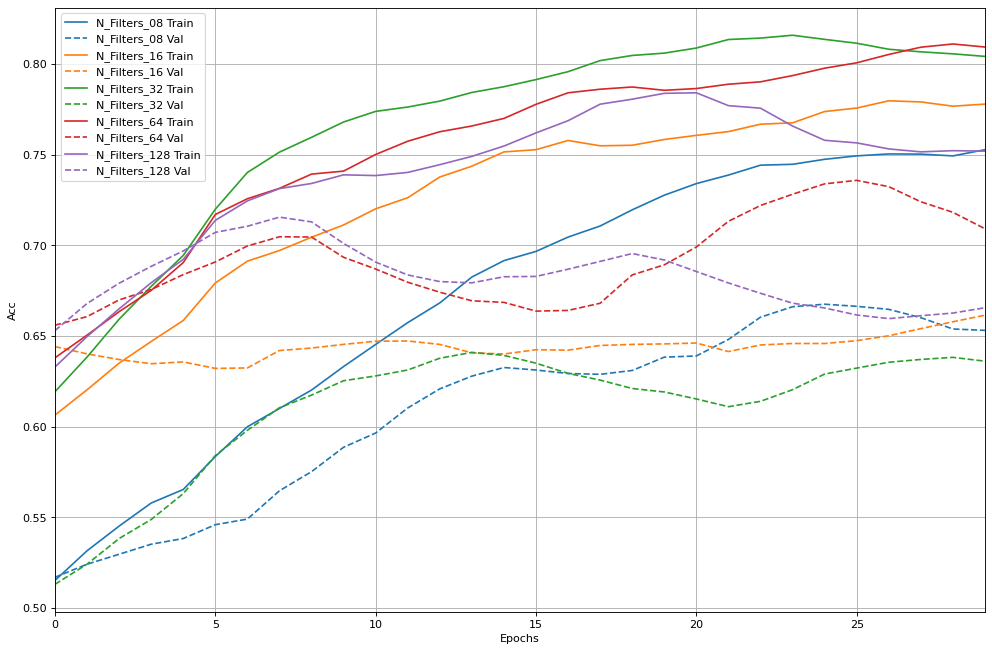

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc', smoothing_std=1)
figure(figsize=(15, 10), dpi=80)

plotter.plot(models_histories)

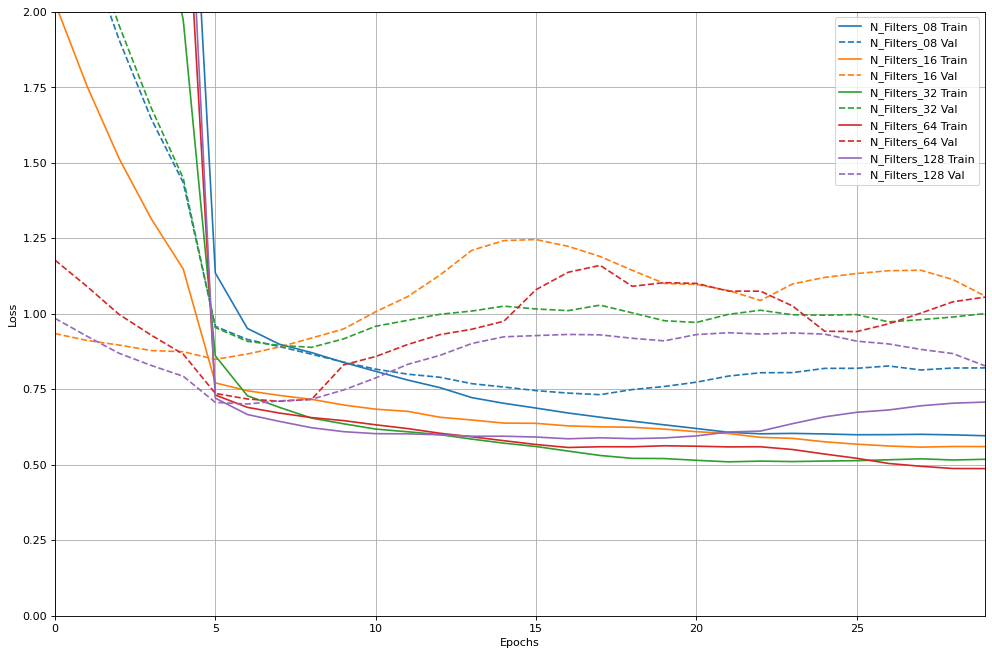

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=1)
figure(figsize=(15, 10), dpi=80)
plt.ylim([0, 2])
plotter.plot(models_histories)